In [98]:
import os
import numpy as np
import pandas as pd
import mne
import scipy.io
import matplotlib.pyplot as plt
from mne.decoding import CSP
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP



In [99]:
filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230713'
brainAdress = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5',
'FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3',
'P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2',
'AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2',
'FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4',
'P6','P8','P10','PO8','PO4','O2']
# dataクラス
class O_Data:
    def __init__(self, eeg, index, label):
        self.eeg = eeg
        self.index = index
        self.label = label
        self.stack = []
o_data65_label1 = list()#label1のデータ
o_data = list()
label_data = list()#labelを結合したデータ
all_data = list()  # 全データを結合
file_name = list()  # すべての.matファイルの名前

In [100]:
for file in os.listdir(filePath):
    base, ext = os.path.splitext(file)
    if ext == '.mat':
        file_name = sorted(file_name)
        file_name.append(file)
print('Filelist')
print(file_name)
#解析するデータを選択
#file_name1 = [file_name[2],file_name[9],file_name[3],file_name[4]]
file_name1 = [file_name[5],file_name[6],file_name[7],file_name[8]]
file_num1 = len(file_name1)
trial_num = 30
all_trial = len(file_name1) * trial_num
all_d = 0
CH = 64
#label1を読み込む
for s in range(file_num1):
    Dictionary = scipy.io.loadmat(filePath+"/"+file_name1[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:66, :]
                index = b[1]
                samplerate = b[2]
                label = b[5][0, 0]
                o_data = O_Data(eeg, index, label)
                o_data65_label1.append(o_data)
print("image data_loading")
print(file_name1)

Filelist
['EEG_grasping_13-Jul-2023_sub1-1.mat', 'EEG_grasping_13-Jul-2023_sub1-2.mat', 'EEG_grasping_13-Jul-2023_sub2-1.mat', 'EEG_grasping_13-Jul-2023_sub2-3.mat', 'EEG_grasping_13-Jul-2023_sub2-4.mat', 'EEG_grasping_13-Jul-2023_sub3-1.mat', 'EEG_grasping_13-Jul-2023_sub3-2.mat', 'EEG_grasping_13-Jul-2023_sub3-3.mat', 'EEG_grasping_13-Jul-2023_sub3-4.mat', 'EEG_grasping_13-Jul-2023_sub2-2.mat']
image data_loading
['EEG_grasping_13-Jul-2023_sub3-1.mat', 'EEG_grasping_13-Jul-2023_sub3-2.mat', 'EEG_grasping_13-Jul-2023_sub3-3.mat', 'EEG_grasping_13-Jul-2023_sub3-4.mat']


In [101]:
#eeg_data
c1 = o_data65_label1[0].eeg[0:64 , 0:10240]
for n in range(len(file_name1)*trial_num-1):  # all_trial
    g1 = o_data65_label1[n+1].eeg[0:64 , 0:10240]
    c1 = np.dstack([c1, g1])
all_data = c1.transpose(2,0,1)
print(np.shape(all_data))
all_data = all_data.astype(np.double)
#label
label_data = list()#labelを結合したデータ
for n in range(all_trial):
    label_data.append(o_data65_label1[n].label)
label_data = np.array(label_data)
print(np.shape(label_data))

(120, 64, 10240)
(120,)


In [102]:
n_channels = 64
sampling_freq = 1024  # in Hertz
info = mne.create_info(ch_names=brainAdress, ch_types="eeg", sfreq=sampling_freq)
info.set_montage('standard_1020')

events = np.column_stack(
    (
        np.arange(0, 1024*120, sampling_freq),
        np.zeros(120, dtype=int),
        label_data
    )
)
event_dict = dict(condition_A=1, condition_B=2)
simulated_epochs = mne.EpochsArray(
    all_data, info, tmin=-6, events=events, event_id=event_dict,baseline=(-6,-3)
)

Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [103]:
resample_freq = 100
resample_epochs = simulated_epochs.resample(sfreq=resample_freq)

In [104]:
print(resample_epochs.info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 100.0 Hz
>


In [105]:
data_flit = resample_epochs.filter(l_freq=1.0,h_freq=40)
ica = mne.preprocessing.ICA(n_components=20,random_state=42,max_iter=800)
ica.fit(data_flit)

Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 64 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 7680 out of 7680 | elapsed:    0.4s finished
/var/folders/ns/k3cfj44n0x5fzgb4dy4t3l0c0000gn/T/ipykernel_30585/3055075430.py:3: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data_flit)


Selecting by number: 20 components
Fitting ICA took 2.4s.


Method,fastica
Fit,46 iterations on epochs (120000 samples)
ICA components,20
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


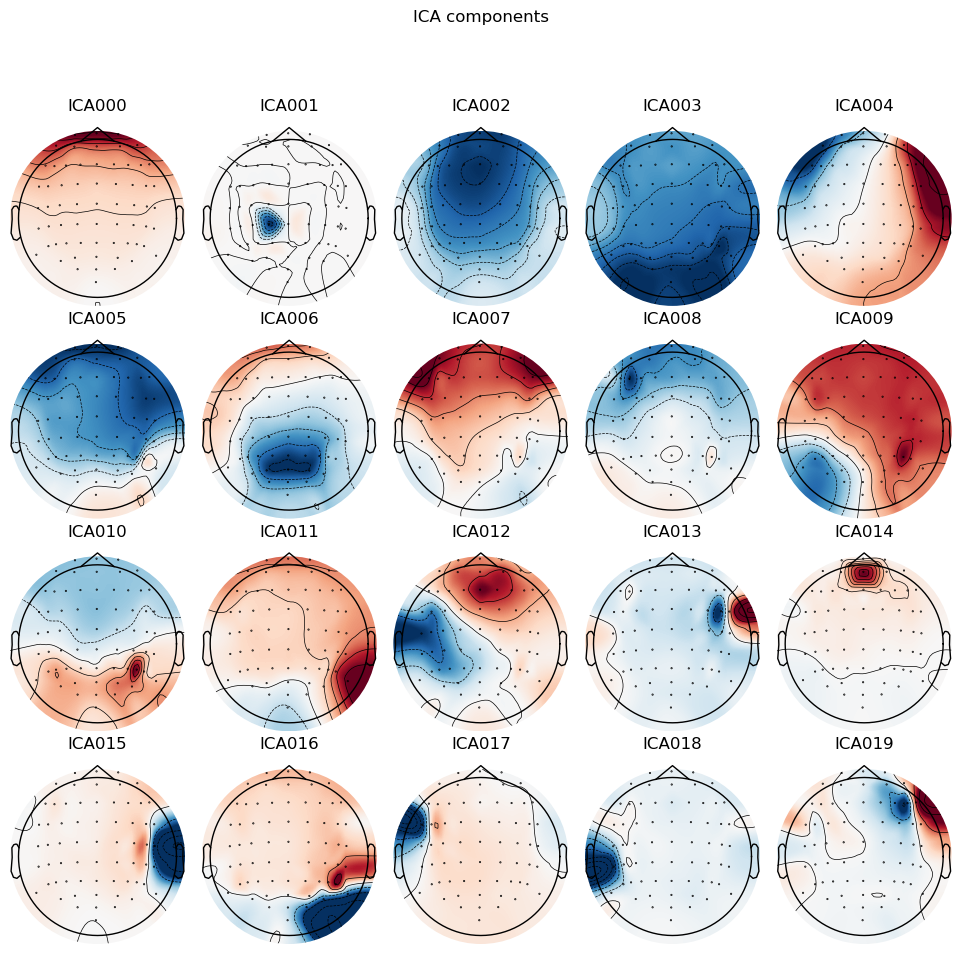

[<MNEFigure size 975x967 with 20 Axes>]

In [106]:
ica.plot_components()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated


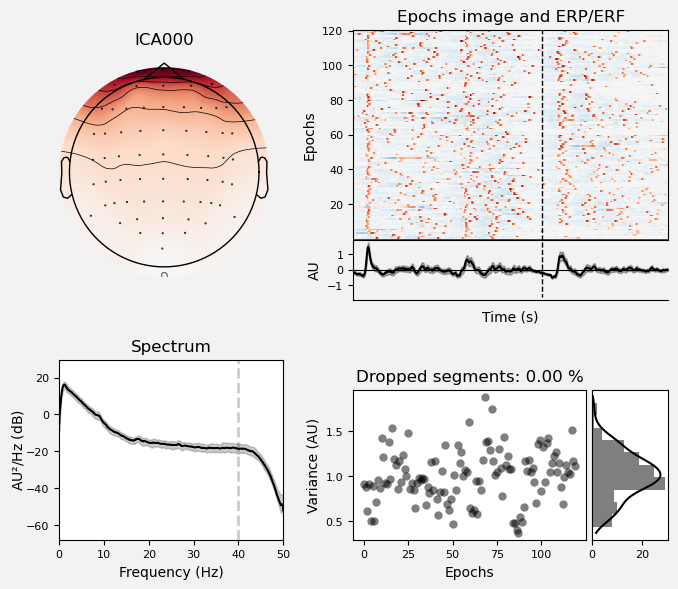

[<Figure size 700x600 with 6 Axes>]

In [122]:
ica.exclude = [0]
ica.plot_properties(data_flit,picks=ica.exclude)

In [108]:
data_ica = data_flit.copy()
ica.apply(data_ica)

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


/var/folders/ns/k3cfj44n0x5fzgb4dy4t3l0c0000gn/T/ipykernel_30585/143510216.py:2: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(data_ica)


Number of events,120
Events,condition_A: 60condition_B: 60
Time range,-6.000 – 3.990 sec
Baseline,-6.000 – -3.000 sec


In [109]:
data_ica.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 1.0 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 100.0 Hz
>

In [110]:
data_kaiseki = data_ica.get_data()

In [111]:
np.shape(data_kaiseki)

(120, 64, 1000)

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/Users/yaman/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/var/folders/ns/k3cfj44n0x5fzgb4dy4t3l0c0000gn/T/ipykernel_30585/2556232609.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  data_flit.compute_psd(fmax=50).plot().show()


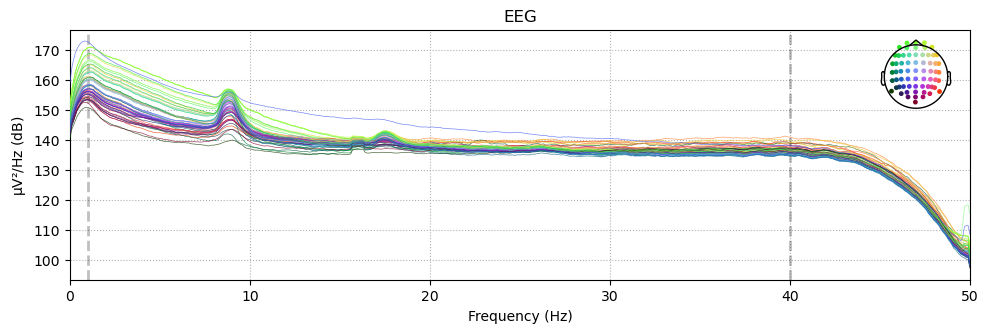

In [112]:
data_flit.compute_psd(fmax=50).plot().show()

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/Users/yaman/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/var/folders/ns/k3cfj44n0x5fzgb4dy4t3l0c0000gn/T/ipykernel_30585/1857669653.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  data_ica.compute_psd(fmax=50).plot().show()


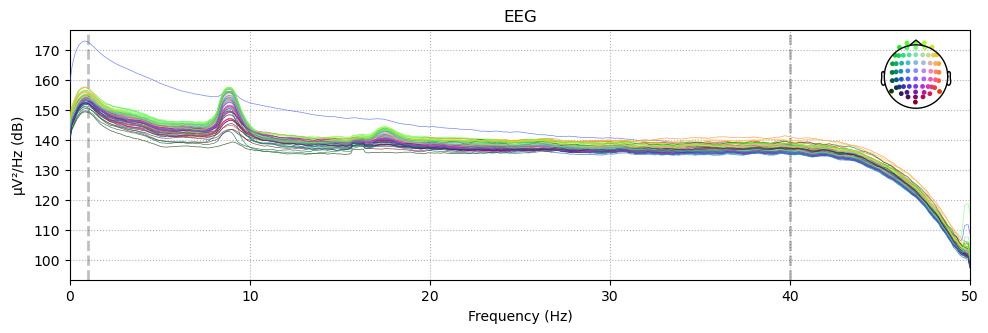

In [113]:
data_ica.compute_psd(fmax=50).plot().show()

In [114]:
extension_epochs = data_ica["condition_A"]
flexion_epochs = data_ica["condition_B"]

In [115]:
# extension_epochs.plot_image(picks=brainAdress)

In [116]:
#flexion_epochs.plot_image(picks=brainAdress)

combining channels using "gfp"
combining channels using "gfp"


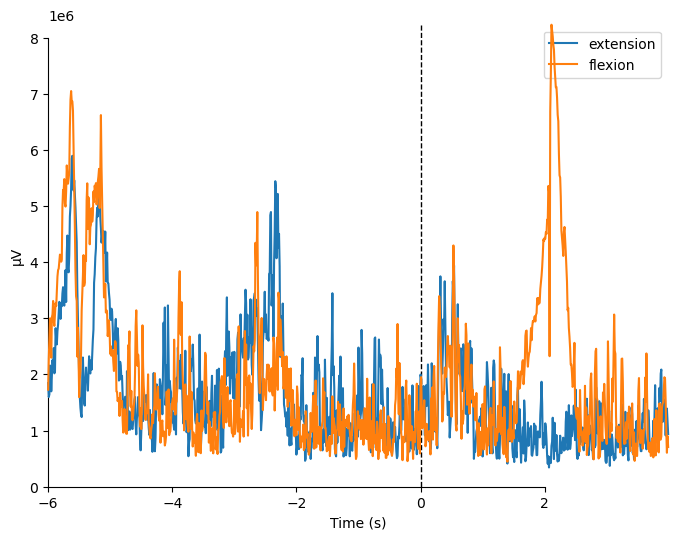

[<Figure size 800x600 with 1 Axes>]

In [117]:
extension_evoked = extension_epochs.average()
flexion_evoked = flexion_epochs.average()

mne.viz.plot_compare_evokeds(
    dict(extension=extension_evoked, flexion=flexion_evoked),
    legend="upper right"
)

In [118]:
extension_psd = extension_evoked.compute_psd(fmax=50)
flexion_psd = flexion_evoked.compute_psd(fmax=50)

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


/Users/yaman/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/Users/yaman/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


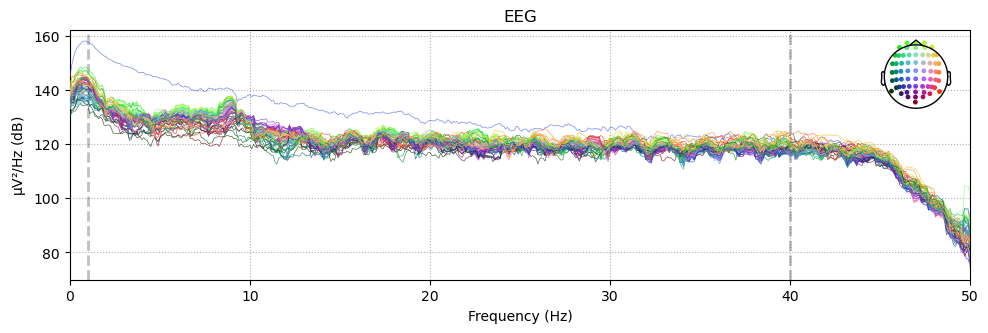

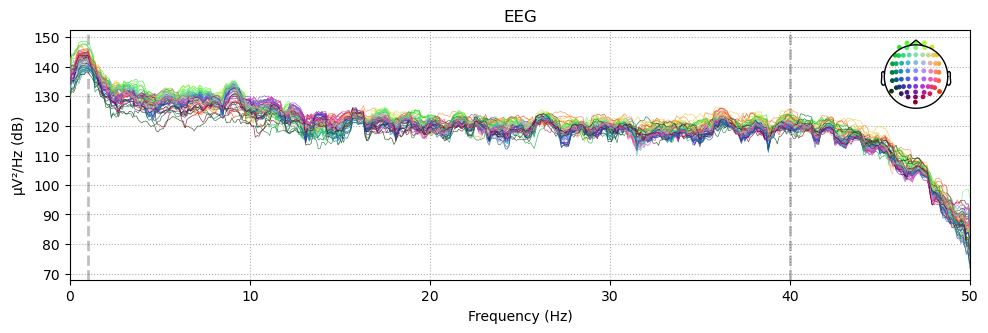

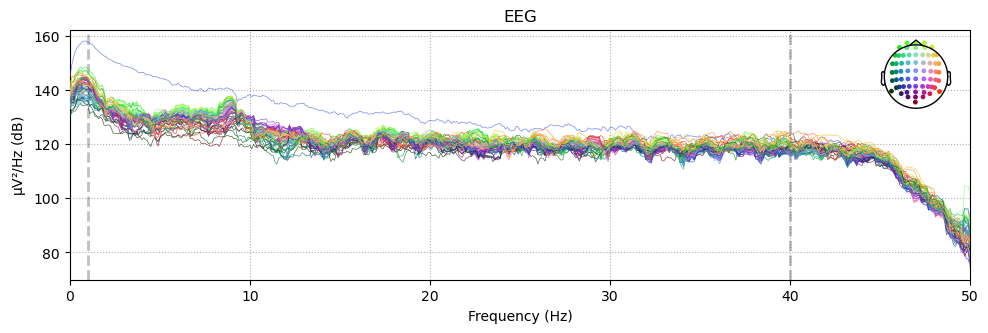

In [119]:
extension_psd.plot(picks="data",exclude="bads")
flexion_psd.plot(picks="data",exclude="bads")

In [127]:
from mne_icalabel import label_components
label_components(data_ica, ica, method='iclabel')

/var/folders/ns/k3cfj44n0x5fzgb4dy4t3l0c0000gn/T/ipykernel_30585/884543154.py:2: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  label_components(data_ica, ica, method='iclabel')
/var/folders/ns/k3cfj44n0x5fzgb4dy4t3l0c0000gn/T/ipykernel_30585/884543154.py:2: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  label_components(data_ica, ica, method='iclabel')
/var/folders/ns/k3cfj44n0x5fzgb4dy4t3l0c0000gn/T/ipykernel_30585/884543154.py:2: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA

{'y_pred_proba': array([0.7599883 , 0.68776023, 0.93386424, 0.85011846, 0.91177225,
        0.8330053 , 0.9942343 , 0.7347188 , 0.59171003, 0.9842205 ,
        0.9808755 , 0.5673337 , 0.9567574 , 0.4159584 , 0.40973645,
        0.9085321 , 0.38591424, 0.6196582 , 0.53234875, 0.8293397 ],
       dtype=float32),
 'labels': ['other',
  'channel noise',
  'brain',
  'heart beat',
  'eye blink',
  'other',
  'brain',
  'brain',
  'brain',
  'brain',
  'brain',
  'other',
  'brain',
  'muscle artifact',
  'brain',
  'muscle artifact',
  'brain',
  'other',
  'brain',
  'muscle artifact']}